In [4]:
import requests
gene_id = 'ENSG00000165269'
efo_id = 'EFO_0003843'
size = '50'
url = (
    'https://platform-api.opentargets.io/v3/platform/public/evidence/filter?size=' 
    + size 
    + '&datasource=chembl&fields=disease.efo_info&fields=drug&fields=evidence&fields=target&fields=access_level&disease='
    + efo_id 
    + '&expandefo=true'
) 
r = requests.get(url)

data = r.json()

all_drugs_data = data['data']

print(len(all_drugs_data))

50


In [5]:
drugs_data_simple = []

for entry in all_drugs_data:
    target_symbol = entry['target']['gene_info']['symbol']
    disease_label = entry['disease']['efo_info']['label']
    drug_name = entry['drug']['molecule_name']
    drug_phase = entry['evidence']['drug2clinic']['clinical_trial_phase']['numeric_index']
    drug_status = entry['evidence']['drug2clinic'].get('status', 'n/a')
    drug_obj = {
        'target': target_symbol,
        'disease': disease_label,
        'drug': drug_name,
        'phase': drug_phase,
        'status': drug_status,
    }
    drugs_data_simple.append(drug_obj)

print(len(drugs_data_simple))
print(drugs_data_simple[0])

50
{'target': 'OPRM1', 'disease': 'pain', 'drug': 'FENTANYL', 'phase': 4, 'status': 'Completed'}


In [6]:
import pandas as pd

drugs_df = pd.DataFrame(drugs_data_simple)

print(len(drugs_df))
drugs_df.head()

50


,disease,drug,phase,status,target
0,pain,FENTANYL,4,Completed,OPRM1
1,pain,ETORICOXIB,4,Completed,PTGS2
2,pain,HYDROMORPHONE,4,n/a,OPRM1
3,pain,ROPIVACAINE,4,Recruiting,SCN3A
4,pain,ROPIVACAINE,4,Not yet recruiting,SCN3A


In [11]:
cols_to_aggregate = ['disease', 'drug', 'phase', 'status', 'target']

aggregated_drugs_df = drugs_df.groupby(cols_to_aggregate).size().reset_index(name='num_ev_strings').sort_values(by='num_ev_strings', ascending=False)

print(len(aggregated_drugs_df))
aggregated_drugs_df.head()

46


,disease,drug,phase,status,target,num_ev_strings
9,pain,ACETAMINOPHEN,4,n/a,PTGS1,3
44,pain,TRAMADOL,4,n/a,OPRM1,2
11,pain,ACETAMINOPHEN,4,n/a,TRPV1,2
0,Renal Colic,ACETAMINOPHEN,4,Suspended,TRPV1,1
34,pain,PROPOFOL,4,Completed,GABRA6,1


In [12]:
file_name = 'reports/aggregated_drug_evidence_' + efo_id + '.csv'

aggregated_drugs_df.to_csv(file_name, encoding='utf-8')

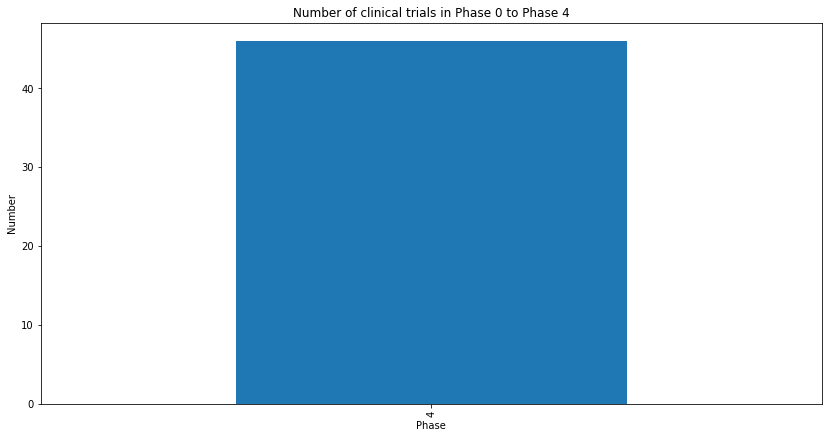

In [18]:
import matplotlib.pyplot as plt

ax = aggregated_drugs_df['phase']
    .value_counts().plot(kind='bar', figsize=(14,7), title="Number of clinical trials in Phase 0 to Phase 4")
ax.set_xlabel("Phase")
ax.set_ylabel("Number")
plt.show()